[*********************100%***********************]  1 of 1 completed
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21216\2208863947.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(['Date', 'Adj Close'], axis = 1)


(1733, 7)
(743, 7)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'x_test' is not defined

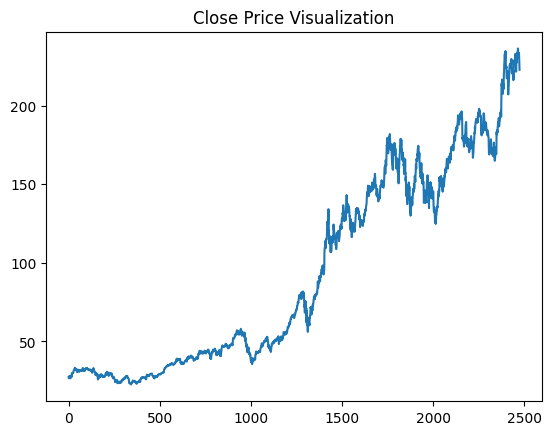

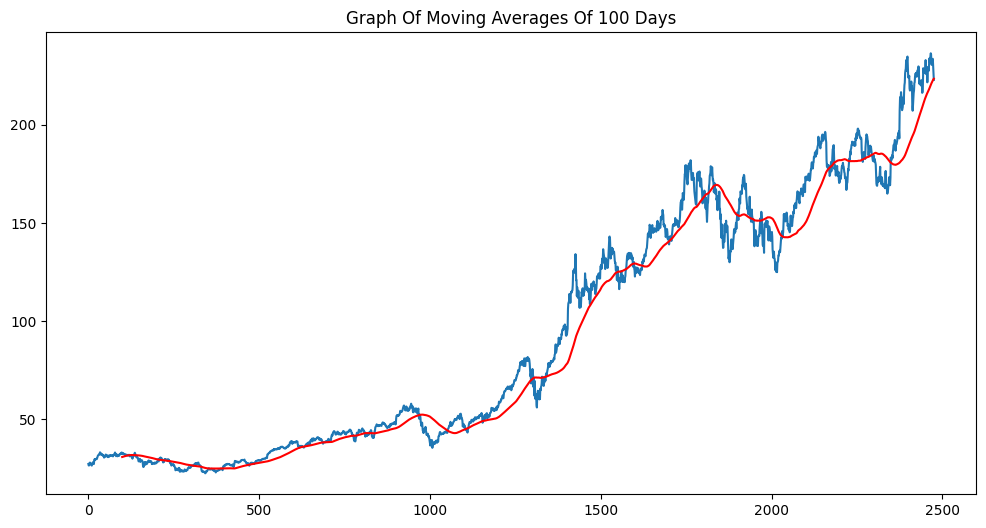

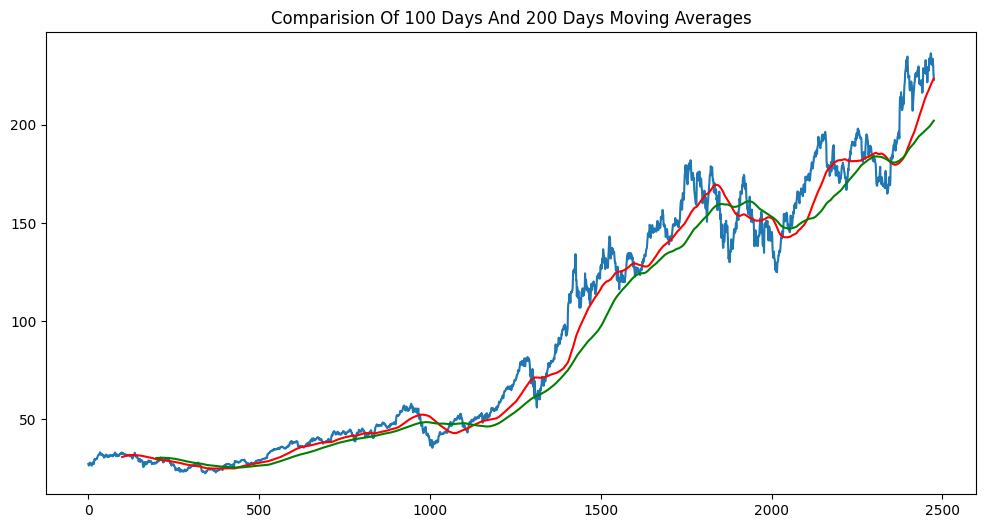

In [1]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf


START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")


# Define a function to load the dataset


def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data
data = load_data('AAPL')
df=data
df.head()
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()
plt.title("Close Price Visualization")
plt.plot(df.Close)
df
ma100 = df.Close.rolling(100).mean()
ma100
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')
ma200 = df.Close.rolling(200).mean()
ma200
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')
# Splitting data into training and testing


train = pd.DataFrame(data[0:int(len(data)*0.70)])
test = pd.DataFrame(data[int(len(data)*0.70): int(len(data))])


print(train.shape)
print(test.shape)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values
data_training_array = scaler.fit_transform(train_close)
data_training_array
x_train = []
y_train = []


for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))


model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])
model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs = 50)
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)
